1. VIF활용
  - VIF는 한 특징을 라벨로 간주하고, 해당 라벨을 예측하는데 다른 특징을 사용한 회귀 모델이 높은 R^2을 보이는 경우 해당 특징이 다른 특징과 상관성이 있다고 판단함
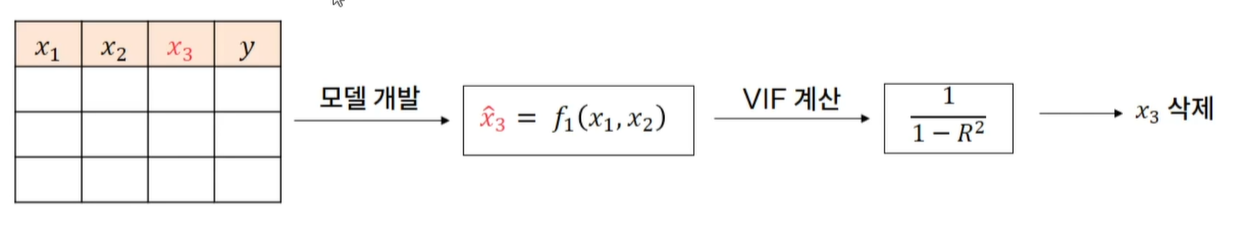
  - VIF가 높은 순서대로 특징을 제거하거나, VIF가 10이상인 경우 주로 삭제한다.

2. 주성분 분석
  - 주성분 분석을 이용하여 특징이 서로 직교하도록 만들어 특징간 상관성을 줄이는 방법도 존재
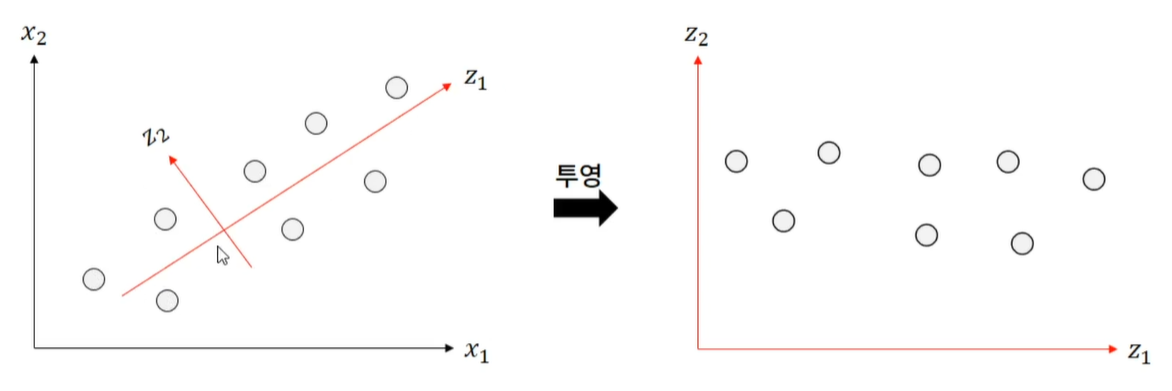
  - n차원의 데이터는 총 n개의 주성분이 존재하지만, 차원 축소 등을 위해 분산의 대부분을 설명하는 m < n 주성분만 사용

### sklearn.decomposition.PCA
- 주성분 분석을 수행하는 인스턴스를 생성하는 함수
- 주요 입력
  - n_components: 사용할 주성분 개수를 나타내며, 이 값은 기존 차원 수보다 작아야 함
- 주요 attribute
  - explained_variance_ratio_: 각 주성분이 원 데이터의 분산을 설명하는 정도

In [2]:
import os
import pandas as pd
os.chdir(r'C:\Users\신상훈\Desktop\preprocessing\part-5.-머신러닝-모델의-성능-향상을-위한-전처리\5. 머신러닝 모델의 성능 향상을 위한 전처리\데이터')

In [3]:
df = pd.read_csv('abalone.csv')

In [4]:
df.head()

,Length,Diameter,Height,Wholeweight,Shuckedweight,Visceraweight,Shellweight,Age
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [5]:
# 특징과 라벨 분리
X = df.drop(['Age'], axis = 1)
Y = df['Age']

In [6]:
# 학습 데이터와 평가 데이터 분리
from sklearn.model_selection import train_test_split
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X,Y)

In [9]:
Train_X.shape

(3132, 7)

In [10]:
Train_X.corr() # 특징 간 상관 행렬 출력 => 얼핏봐도 특징 간 선형 관계가 존재

,Length,Diameter,Height,Wholeweight,Shuckedweight,Visceraweight,Shellweight
Length,1.000000,0.987557,0.807575,0.924920,0.897150,0.902199,0.899312
Diameter,0.987557,1.000000,0.813921,0.925905,0.893397,0.899396,0.906980
Height,0.807575,0.813921,1.000000,0.798316,0.756962,0.777406,0.796826
Wholeweight,0.924920,0.925905,0.798316,1.000000,0.968808,0.966629,0.955434
Shuckedweight,0.897150,0.893397,0.756962,0.968808,1.000000,0.932333,0.883459
Visceraweight,0.902199,0.899396,0.777406,0.966629,0.932333,1.000000,0.908469
Shellweight,0.899312,0.906980,0.796826,0.955434,0.883459,0.908469,1.000000


#### VIF 기준 특징 선택

In [11]:
# VIF 계산
from sklearn.linear_model import LinearRegression as LR
VIF_dict = dict()
for col in Train_X.columns:
    model = LR().fit(Train_X.drop([col],axis = 1), Train_X[col])
    r2 = model.score(Train_X.drop([col], axis = 1), Train_X[col]) # LinearRegression의 score가 r2 점수임
    VIF = 1 / (1 - r2)
    VIF_dict[col] = VIF

In [13]:
VIF_dict # Height를 제외하곤 VIF가 모두 높으므로, 이러한 상황에서는 사실 PCA를 사용하는 것이 바람직

{'Length': 42.87799672019288,
 'Diameter': 44.37847821664728,
 'Height': 3.160561339278884,
 'Wholeweight': 100.91883159531659,
 'Shuckedweight': 26.264243286847236,
 'Visceraweight': 17.1455013473948,
 'Shellweight': 20.160582228136654}

In [15]:
from sklearn.neural_network import MLPRegressor as MLP
from sklearn.metrics import mean_absolute_error as MAE

In [16]:
# 전체 특징을 모두 사용하였을 때
model = MLP(random_state = 2313, max_iter = 500)
model.fit(Train_X, Train_Y)
pred_Y = model.predict(Test_X)
score = MAE(Test_Y, pred_Y)
print(score)

1.636120570229102


In [17]:
# VIF 점수가 30점 미만인 특징만 사용하였을 때 
selected_features = [key for key, val in VIF_dict.items() if val < 30] 
model = MLP(random_state = 2313, max_iter = 500)
model.fit(Train_X[selected_features], Train_Y)
pred_Y = model.predict(Test_X[selected_features])
score = MAE(Test_Y, pred_Y)
print(score)

1.6087292895385599


C:\Users\신상훈\AppData\Roaming\Python\Python38\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


#### PCA 사용

In [18]:
from sklearn.decomposition import PCA
PCA_model = PCA(n_components = 3).fit(Train_X)

Train_Z = PCA_model.transform(Train_X)
Test_Z = PCA_model.transform(Test_X)

print(Train_Z.shape)

(3132, 3)


In [19]:
model = MLP(random_state = 2313, max_iter = 500)
model.fit(Train_Z, Train_Y)
pred_Y = model.predict(Test_Z)
score = MAE(Test_Y, pred_Y)
print(score)

1.5330789973878283
